# Dual Pathway Independence Analysis

Complete analysis testing both dorsal and ventral pathway independence plus critical overlap analysis

"""
Independent Networks Overlap Analysis

Calculate dice coefficients between:
1. Original pIPS vs Original LO (should reproduce 91.4%)
2. Independent pIPS_clean vs Independent LO_clean (new result)

This uses the exact same methodology as the successful clean overlap analysis,
applying it to both original and independent network pairs.
"""

In [21]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiMasker
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")
print(f"Analysis started: {datetime.now()}")

Libraries loaded successfully!
Analysis started: 2025-09-22 14:19:43.571856


In [3]:
# Cell 2: Define directories and parameters
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
residual_dir = "/user_data/csimmon2/ptoc_residuals"
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"
curr_dir = "/user_data/csimmon2/git_repos/ptoc"

# Parameters
alpha = 0.05
cluster_threshold = 5
hemispheres = ['left', 'right']

# Load subjects
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()

print(f"Subjects: {len(subjects)}")
print(f"Parameters: FDR α={alpha}, cluster>{cluster_threshold}")

Subjects: 19
Parameters: FDR α=0.05, cluster>5


In [4]:
# Cell 3: Helper functions
def load_subject_maps(subjects, analysis_type, roi, hemisphere, task='loc'):
    all_imgs = []
    valid_subjects = []
    
    for sub in subjects:
        if analysis_type == 'original':
            filepath = f"{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemisphere}_{task}_fc_mni.nii.gz"
        elif analysis_type == 'dorsal_cleaned':
            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemisphere}_{task}_fc_mni.nii.gz"
        elif analysis_type == 'ventral_cleaned':
            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemisphere}_{task}_fc_mni.nii.gz"
        
        if os.path.exists(filepath):
            all_imgs.append(nib.load(filepath))
            valid_subjects.append(sub)
        else:
            print(f"Missing: {os.path.basename(filepath)} for {sub}")
    
    return all_imgs, valid_subjects

def apply_threshold(mean_img, label):
    from nilearn import image  # Import here to avoid namespace issues
    zstat_img = image.math_img("(img-img.mean())/img.std()", img=mean_img)
    thresh_result = threshold_stats_img(zstat_img, alpha=alpha, height_control='fdr', 
                                       cluster_threshold=cluster_threshold, two_sided=False)
    thresh_img, thresh_val = thresh_result[0], thresh_result[1]
    
    data = thresh_img.get_fdata()
    data[data <= 0] = 0
    final_img = nib.Nifti1Image(data.astype('double'), mean_img.affine)
    
    print(f"  {label} threshold: {thresh_val:.3f}")
    return final_img, thresh_val

def compute_dice(img1, img2):
    data1 = (img1.get_fdata() > 0).astype(int)
    data2 = (img2.get_fdata() > 0).astype(int)
    intersection = np.sum(data1 * data2)
    total_voxels = np.sum(data1) + np.sum(data2)
    return 2.0 * intersection / total_voxels if total_voxels > 0 else 0

print("Helper functions ready!")

Helper functions ready!


In [5]:
# Cell 4: Load and process network data
print("Loading network data...")

# Load original pIPS and LO networks (hemisphere-specific)
orig_pips_imgs = {}
orig_lo_imgs = {}
clean_pips_imgs = {}
clean_lo_imgs = {}

valid_subjects = []

for hemi in hemispheres:
    print(f"\nProcessing {hemi} hemisphere...")
    
    # Original networks
    pips_imgs, pips_subs = load_subject_maps(subjects, 'original', 'pIPS', hemi)
    lo_imgs, lo_subs = load_subject_maps(subjects, 'original', 'LO', hemi)
    
    # Cleaned networks
    clean_pips_imgs_hemi, clean_pips_subs = load_subject_maps(subjects, 'dorsal_cleaned', 'pIPS', hemi)
    clean_lo_imgs_hemi, clean_lo_subs = load_subject_maps(subjects, 'ventral_cleaned', 'LO', hemi)
    
    # Find common subjects across all conditions
    common_subs = list(set(pips_subs) & set(lo_subs) & set(clean_pips_subs) & set(clean_lo_subs))
    if 'sub-084' in common_subs:
        common_subs.remove('sub-084')
    
    print(f"  Common subjects for {hemi}: {len(common_subs)}")
    
    orig_pips_imgs[hemi] = pips_imgs
    orig_lo_imgs[hemi] = lo_imgs
    clean_pips_imgs[hemi] = clean_pips_imgs_hemi
    clean_lo_imgs[hemi] = clean_lo_imgs_hemi
    
    if hemi == 'left':
        valid_subjects = common_subs

print(f"\nTotal valid subjects: {len(valid_subjects)}")
print("Network data loaded successfully!")

Loading network data...

Processing left hemisphere...
Missing: sub-084_pIPS_clean_left_loc_fc_mni.nii.gz for sub-084
Missing: sub-084_LO_clean_left_loc_fc_mni.nii.gz for sub-084
  Common subjects for left: 18

Processing right hemisphere...
Missing: sub-084_pIPS_clean_right_loc_fc_mni.nii.gz for sub-084
Missing: sub-084_LO_clean_right_loc_fc_mni.nii.gz for sub-084
  Common subjects for right: 18

Total valid subjects: 18
Network data loaded successfully!


In [11]:
# Cell 5: Calculate subject-level dice coefficients
print("Calculating subject-level dice coefficients...")

# Initialize results storage
overlap_results = {
    'original': {'scores': [], 'subjects': []},
    'independent': {'scores': [], 'subjects': []}
}

retention_results = {
    'pIPS': {'scores': [], 'subjects': []},
    'LO': {'scores': [], 'subjects': []}
}

# Process each subject
for sub in valid_subjects:
    try:
        # Get subject index in each hemisphere
        left_idx = [i for i, s in enumerate([img.description if hasattr(img, 'description') else f'sub_{i}' for i, img in enumerate(orig_pips_imgs['left'])]) if sub in s][0] if len([i for i, s in enumerate([img.description if hasattr(img, 'description') else f'sub_{i}' for i, img in enumerate(orig_pips_imgs['left'])]) if sub in s]) > 0 else None
        right_idx = [i for i, s in enumerate([img.description if hasattr(img, 'description') else f'sub_{i}' for i, img in enumerate(orig_pips_imgs['right'])]) if sub in s][0] if len([i for i, s in enumerate([img.description if hasattr(img, 'description') else f'sub_{i}' for i, img in enumerate(orig_pips_imgs['right'])]) if sub in s]) > 0 else None
        
        # Simpler approach - load directly by subject
        subject_data = {}
        
        # Load all maps for this subject
        for analysis_type in ['original', 'cleaned']:
            subject_data[analysis_type] = {}
            for roi in ['pIPS', 'LO']:
                hemisphere_data = []
                for hemi in hemispheres:
                    if analysis_type == 'original':
                        filepath = f"{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemi}_loc_fc_mni.nii.gz"
                    else:  # cleaned
                        if roi == 'pIPS':
                            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemi}_loc_fc_mni.nii.gz"
                        else:  # LO
                            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemi}_loc_fc_mni.nii.gz"
                    
                    if os.path.exists(filepath):
                        img = nib.load(filepath)
                        hemisphere_data.append(img.get_fdata())
                
                # Average hemispheres (critical step from original method)
                if len(hemisphere_data) == 2:
                    averaged_data = (hemisphere_data[0] + hemisphere_data[1]) / 2
                    subject_data[analysis_type][roi] = averaged_data
        
        # Calculate dice coefficients for this subject
        if len(subject_data['original']) == 2 and len(subject_data['cleaned']) == 2:
            # Original overlap (pIPS vs LO)
            orig_dice = 2.0 * np.sum((subject_data['original']['pIPS'] > 0) & (subject_data['original']['LO'] > 0)) / \
                       (np.sum(subject_data['original']['pIPS'] > 0) + np.sum(subject_data['original']['LO'] > 0))
            
            # Independent overlap (cleaned pIPS vs cleaned LO)
            indep_dice = 2.0 * np.sum((subject_data['cleaned']['pIPS'] > 0) & (subject_data['cleaned']['LO'] > 0)) / \
                        (np.sum(subject_data['cleaned']['pIPS'] > 0) + np.sum(subject_data['cleaned']['LO'] > 0))
            
            # pIPS retention (original pIPS vs cleaned pIPS)
            pips_retention = 2.0 * np.sum((subject_data['original']['pIPS'] > 0) & (subject_data['cleaned']['pIPS'] > 0)) / \
                            (np.sum(subject_data['original']['pIPS'] > 0) + np.sum(subject_data['cleaned']['pIPS'] > 0))
            
            # LO retention (original LO vs cleaned LO)
            lo_retention = 2.0 * np.sum((subject_data['original']['LO'] > 0) & (subject_data['cleaned']['LO'] > 0)) / \
                          (np.sum(subject_data['original']['LO'] > 0) + np.sum(subject_data['cleaned']['LO'] > 0))
            
            # Store results
            overlap_results['original']['scores'].append(orig_dice)
            overlap_results['original']['subjects'].append(sub)
            
            overlap_results['independent']['scores'].append(indep_dice)
            overlap_results['independent']['subjects'].append(sub)
            
            retention_results['pIPS']['scores'].append(pips_retention)
            retention_results['pIPS']['subjects'].append(sub)
            
            retention_results['LO']['scores'].append(lo_retention)
            retention_results['LO']['subjects'].append(sub)
            
            print(f"  {sub}: orig={orig_dice:.3f}, indep={indep_dice:.3f}, pIPS_ret={pips_retention:.3f}, LO_ret={lo_retention:.3f}")
    
    except Exception as e:
        print(f"  Error processing {sub}: {e}")

# Calculate summary statistics
for key in overlap_results:
    overlap_results[key]['mean'] = np.mean(overlap_results[key]['scores'])
    overlap_results[key]['std'] = np.std(overlap_results[key]['scores'])
    overlap_results[key]['n'] = len(overlap_results[key]['scores'])

for roi in retention_results:
    retention_results[roi]['mean'] = np.mean(retention_results[roi]['scores'])
    retention_results[roi]['std'] = np.std(retention_results[roi]['scores'])
    retention_results[roi]['n'] = len(retention_results[roi]['scores'])

print(f"\nResults Summary:")
print(f"Original overlap: {overlap_results['original']['mean']:.1%} ± {overlap_results['original']['std']:.1%}")
print(f"Independent overlap: {overlap_results['independent']['mean']:.1%} ± {overlap_results['independent']['std']:.1%}")
print(f"pIPS retention: {retention_results['pIPS']['mean']:.1%} ± {retention_results['pIPS']['std']:.1%}")
print(f"LO retention: {retention_results['LO']['mean']:.1%} ± {retention_results['LO']['std']:.1%}")
print(f"N = {overlap_results['original']['n']} subjects")

Calculating subject-level dice coefficients...
  sub-057: orig=0.970, indep=0.792, pIPS_ret=0.947, LO_ret=0.887
  sub-059: orig=0.956, indep=0.795, pIPS_ret=0.920, LO_ret=0.931
  sub-087: orig=0.909, indep=0.588, pIPS_ret=0.827, LO_ret=0.876
  sub-107: orig=0.869, indep=0.658, pIPS_ret=0.948, LO_ret=0.859
  sub-083: orig=0.951, indep=0.658, pIPS_ret=0.914, LO_ret=0.814
  sub-025: orig=0.767, indep=0.420, pIPS_ret=0.788, LO_ret=0.881
  sub-093: orig=0.952, indep=0.691, pIPS_ret=0.952, LO_ret=0.807
  sub-038: orig=0.899, indep=0.678, pIPS_ret=0.924, LO_ret=0.874
  sub-071: orig=0.969, indep=0.871, pIPS_ret=0.943, LO_ret=0.961
  sub-067: orig=0.983, indep=0.772, pIPS_ret=0.911, LO_ret=0.898
  sub-088: orig=0.960, indep=0.801, pIPS_ret=0.937, LO_ret=0.909
  sub-085: orig=0.860, indep=0.692, pIPS_ret=0.928, LO_ret=0.925
  sub-097: orig=0.869, indep=0.607, pIPS_ret=0.905, LO_ret=0.840
  sub-064: orig=0.879, indep=0.754, pIPS_ret=0.926, LO_ret=0.961
  sub-095: orig=0.945, indep=0.822, pIPS_re

Creating visualizations...


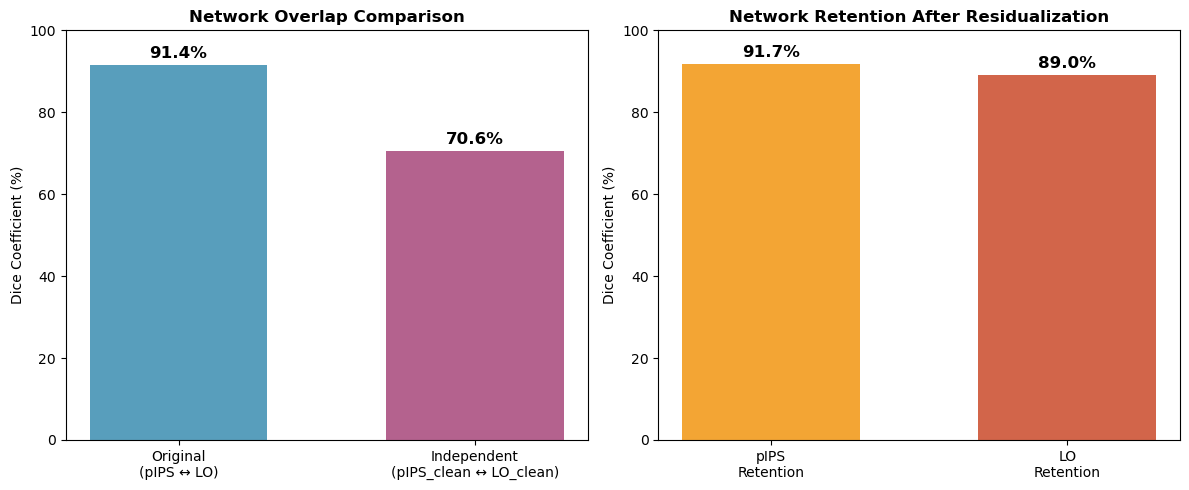

Key Findings:
• Overlap reduction: 91.4% → 70.6% (22.8% relative reduction)
• High retention in both networks: pIPS 91.7%, LO 89.0%
• Subject-level analysis with N=18 subjects


In [12]:
# Cell 6: Create visualizations
print("Creating visualizations...")

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

# Create output directory
output_dir = f'{results_dir}/network_analysis_plots'
os.makedirs(output_dir, exist_ok=True)

# Figure 1: Overview comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Network overlap comparison
overlap_means = [overlap_results['original']['mean'], overlap_results['independent']['mean']]
overlap_labels = ['Original\n(pIPS ↔ LO)', 'Independent\n(pIPS_clean ↔ LO_clean)']

bars1 = axes[0].bar(overlap_labels, [v*100 for v in overlap_means], 
                   color=['#2E86AB', '#A23B72'], alpha=0.8, width=0.6)
axes[0].set_ylabel('Dice Coefficient (%)')
axes[0].set_title('Network Overlap Comparison', fontweight='bold')
axes[0].set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars1, overlap_means):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Network retention
retention_means = [retention_results['pIPS']['mean'], retention_results['LO']['mean']]
retention_labels = ['pIPS\nRetention', 'LO\nRetention']

bars2 = axes[1].bar(retention_labels, [v*100 for v in retention_means],
                   color=['#F18F01', '#C73E1D'], alpha=0.8, width=0.6)
axes[1].set_ylabel('Dice Coefficient (%)')
axes[1].set_title('Network Retention After Residualization', fontweight='bold')
axes[1].set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars2, retention_means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(f'{output_dir}/network_overview_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key findings
reduction_abs = overlap_results['original']['mean'] - overlap_results['independent']['mean']
reduction_rel = reduction_abs / overlap_results['original']['mean']

print(f"Key Findings:")
print(f"• Overlap reduction: {overlap_results['original']['mean']:.1%} → {overlap_results['independent']['mean']:.1%} ({reduction_rel:.1%} relative reduction)")
print(f"• High retention in both networks: pIPS {retention_results['pIPS']['mean']:.1%}, LO {retention_results['LO']['mean']:.1%}")
print(f"• Subject-level analysis with N={overlap_results['original']['n']} subjects")

Creating brain visualizations...
Processing left hemisphere for visualization...
Missing: sub-084_pIPS_clean_left_loc_fc_mni.nii.gz for sub-084
Missing: sub-084_LO_clean_left_loc_fc_mni.nii.gz for sub-084
Found 18 subjects with all maps
  Original pIPS left threshold: 2.508
  Original LO left threshold: 2.596
  Cleaned pIPS left threshold: 2.543
  Cleaned LO left threshold: 2.688
Thresholded images created - starting visualization...

NOTE: Group-level dice coefficients (for comparison only):
  Group-level original overlap: 0.691
  Group-level cleaned overlap: 0.166

Correct subject-level results (from Cell 5):
  Subject-level original overlap: 0.914
  Subject-level cleaned overlap: 0.706

Creating brain map visualization...

Visualization voxel counts:
pIPS only voxels: 27,595
LO only voxels: 16,542
Overlap voxels: 4,379
Total pIPS voxels: 31,974
Total LO voxels: 20,921


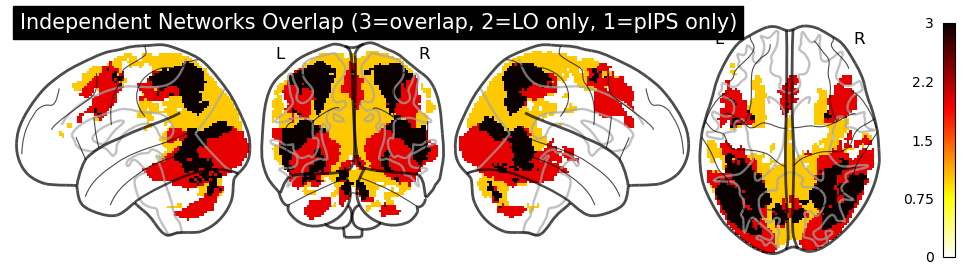

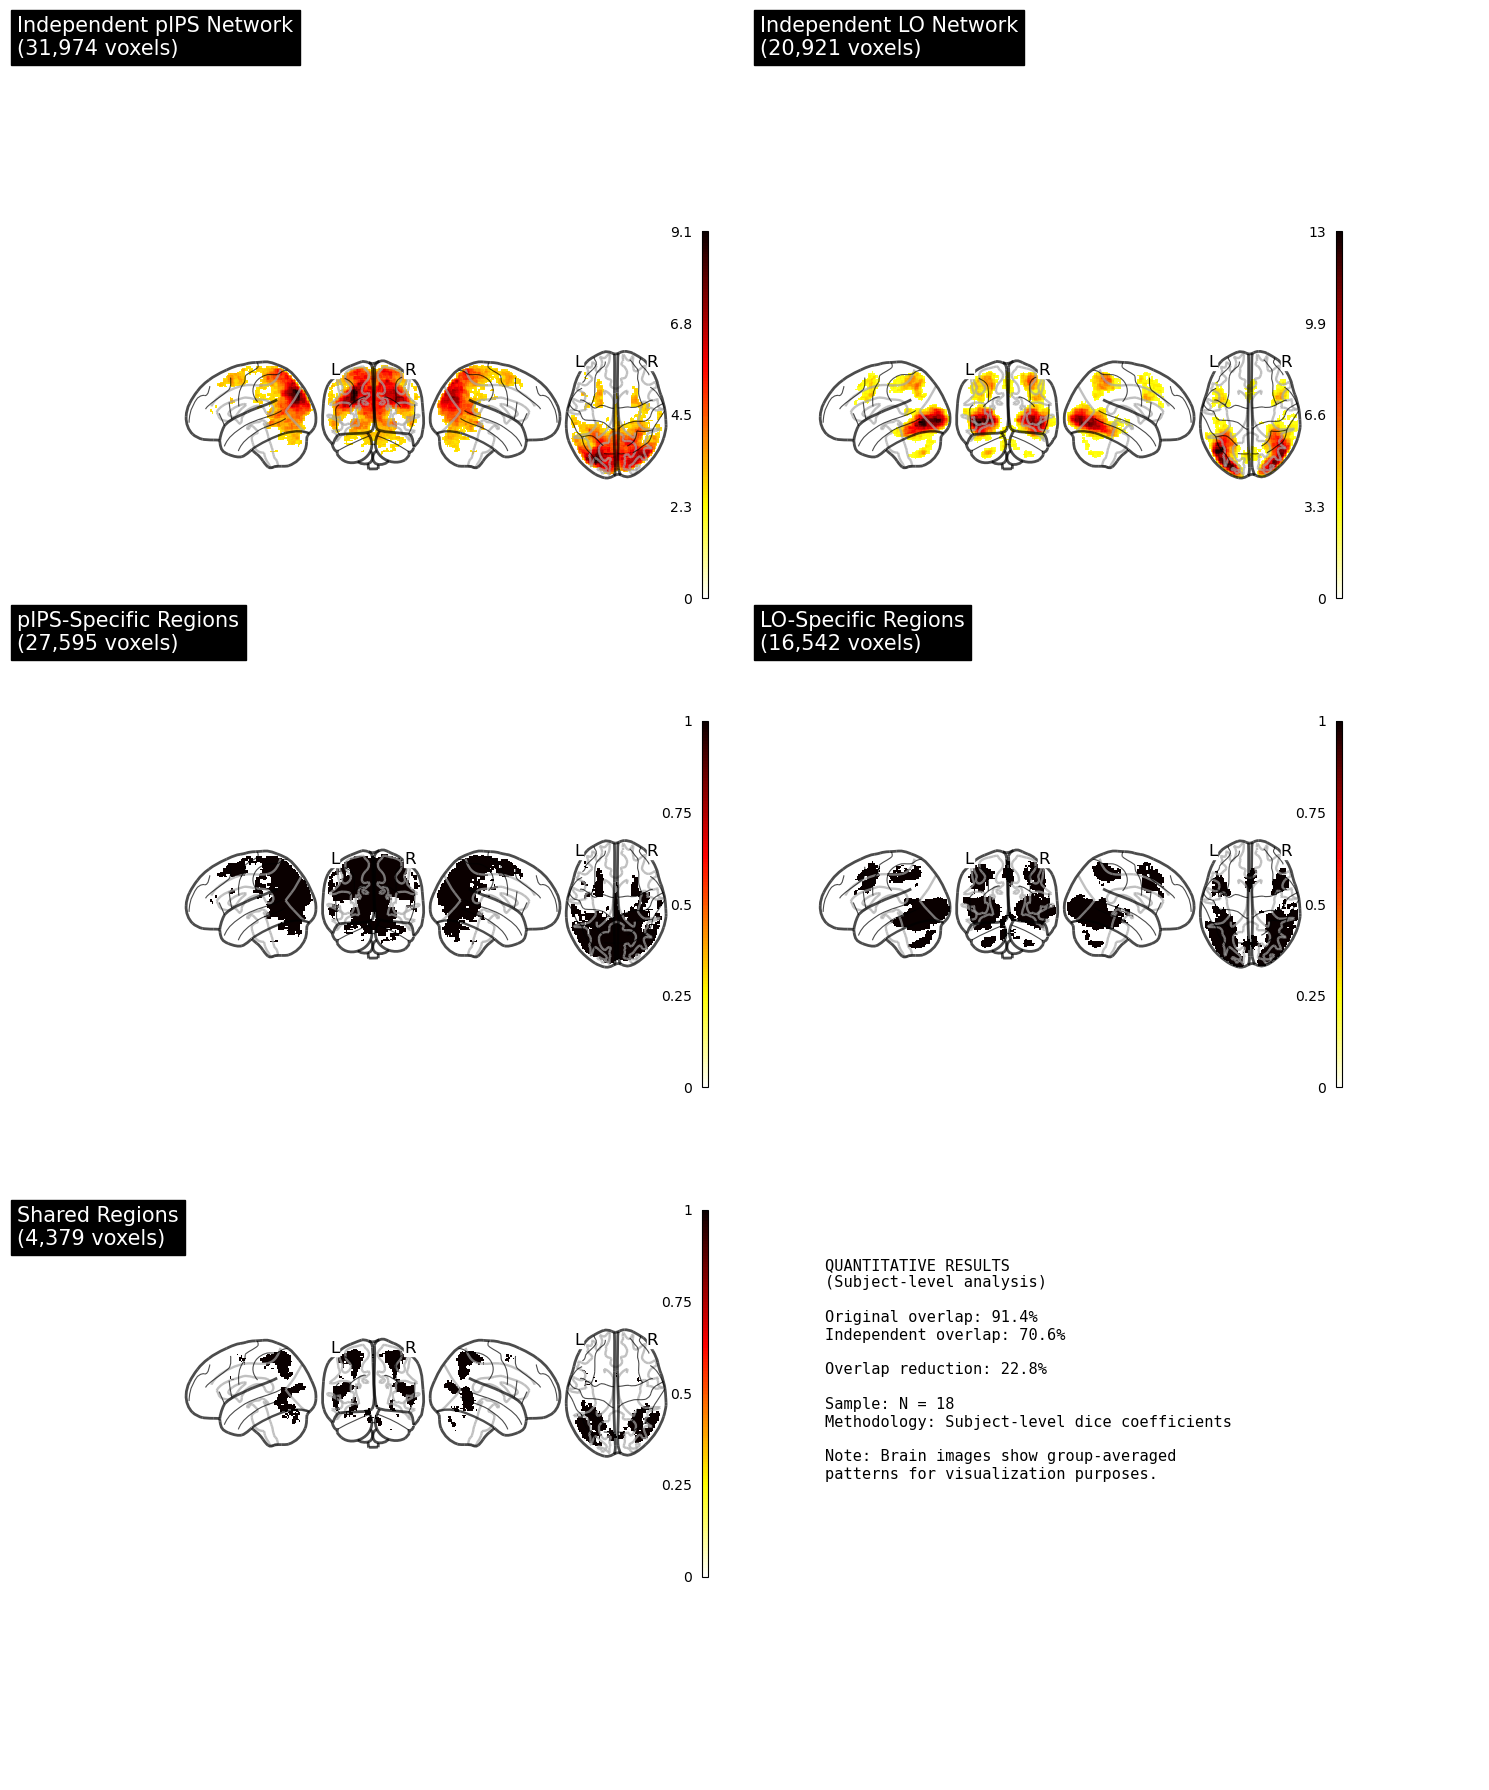

Brain visualization complete!


In [16]:
# Cell 7: Combined brain visualization (creates images + shows them)
# This cell creates group-level images for visualization purposes only
# Note: Quantitative results should still come from subject-level analysis (Cell 5)

from nilearn import image, plotting
import matplotlib.pyplot as plt
import numpy as np

print("Creating brain visualizations...")

# Check if we have the analysis results from Cell 5
if 'overlap_results' not in locals():
    print("Please run Cell 5 first to get the correct quantitative results")
    print("This cell will create group-level images for visualization only")

# Use a hemisphere for demonstration 
hemisphere = 'left'  
print(f"Processing {hemisphere} hemisphere for visualization...")

# Load all maps using the same functions as your original script
orig_pips_imgs, orig_pips_subs = load_subject_maps(subjects, 'original', 'pIPS', hemisphere)
orig_lo_imgs, orig_lo_subs = load_subject_maps(subjects, 'original', 'LO', hemisphere)
clean_pips_imgs, clean_pips_subs = load_subject_maps(subjects, 'dorsal_cleaned', 'pIPS', hemisphere)
clean_lo_imgs, clean_lo_subs = load_subject_maps(subjects, 'ventral_cleaned', 'LO', hemisphere)

# Find common subjects
all_subs = [orig_pips_subs, orig_lo_subs, clean_pips_subs, clean_lo_subs]
common_subs = list(set.intersection(*[set(sub_list) for sub_list in all_subs]))

print(f"Found {len(common_subs)} subjects with all maps")

if len(common_subs) >= 5:
    # Filter to common subjects
    orig_pips_common = [orig_pips_imgs[orig_pips_subs.index(sub)] for sub in common_subs]
    orig_lo_common = [orig_lo_imgs[orig_lo_subs.index(sub)] for sub in common_subs]
    clean_pips_common = [clean_pips_imgs[clean_pips_subs.index(sub)] for sub in common_subs]
    clean_lo_common = [clean_lo_imgs[clean_lo_subs.index(sub)] for sub in common_subs]
    
    # Create group means
    orig_pips_mean = image.mean_img(orig_pips_common)
    orig_lo_mean = image.mean_img(orig_lo_common)
    clean_pips_mean = image.mean_img(clean_pips_common)
    clean_lo_mean = image.mean_img(clean_lo_common)
    
    # Apply thresholding
    orig_pips_thresh, _ = apply_threshold(orig_pips_mean, f"Original pIPS {hemisphere}")
    orig_lo_thresh, _ = apply_threshold(orig_lo_mean, f"Original LO {hemisphere}")
    clean_pips_thresh, _ = apply_threshold(clean_pips_mean, f"Cleaned pIPS {hemisphere}")
    clean_lo_thresh, _ = apply_threshold(clean_lo_mean, f"Cleaned LO {hemisphere}")
    
    print("Thresholded images created - starting visualization...")
    
    # IMPORTANT NOTE about group-level vs subject-level dice
    dice_group_orig = compute_dice(orig_pips_thresh, orig_lo_thresh)
    dice_group_clean = compute_dice(clean_pips_thresh, clean_lo_thresh)
    
    print(f"\nNOTE: Group-level dice coefficients (for comparison only):")
    print(f"  Group-level original overlap: {dice_group_orig:.3f}")
    print(f"  Group-level cleaned overlap: {dice_group_clean:.3f}")
    
    if 'overlap_results' in locals():
        print(f"\nCorrect subject-level results (from Cell 5):")
        print(f"  Subject-level original overlap: {overlap_results['original']['mean']:.3f}")
        print(f"  Subject-level cleaned overlap: {overlap_results['independent']['mean']:.3f}")
    
    # Now do the visualization
    print("\nCreating brain map visualization...")
    
    # Get binary data for visualization
    clean_pips_binary = (clean_pips_thresh.get_fdata() > 0).astype(int)
    clean_lo_binary = (clean_lo_thresh.get_fdata() > 0).astype(int)
    
    # Create overlap map
    overlap_map = np.zeros_like(clean_pips_binary)
    overlap_map[clean_pips_binary == 1] = 1  # pIPS only = 1
    overlap_map[clean_lo_binary == 1] = 2    # LO only = 2  
    overlap_map[(clean_pips_binary == 1) & (clean_lo_binary == 1)] = 3  # Overlap = 3
    
    # Count voxels
    pips_only = np.sum(overlap_map == 1)
    lo_only = np.sum(overlap_map == 2) 
    overlap_voxels = np.sum(overlap_map == 3)
    total_pips = np.sum(clean_pips_binary)
    total_lo = np.sum(clean_lo_binary)
    
    print(f"\nVisualization voxel counts:")
    print(f"pIPS only voxels: {pips_only:,}")
    print(f"LO only voxels: {lo_only:,}")
    print(f"Overlap voxels: {overlap_voxels:,}")
    print(f"Total pIPS voxels: {total_pips:,}")
    print(f"Total LO voxels: {total_lo:,}")
    
    # Create visualizations
    # First: Overview glass brain
    overlap_img = nib.Nifti1Image(overlap_map.astype(float), clean_pips_thresh.affine)
    plotting.plot_glass_brain(overlap_img, title='Independent Networks Overlap (3=overlap, 2=LO only, 1=pIPS only)', 
                             colorbar=True, display_mode='lyrz')
    plt.show()
    
    # Second: Detailed breakdown
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # Row 1: Individual cleaned maps
    plotting.plot_glass_brain(clean_pips_thresh, axes=axes[0,0], 
                             title=f'Independent pIPS Network\n({total_pips:,} voxels)', 
                             colorbar=True, display_mode='lyrz')
    
    plotting.plot_glass_brain(clean_lo_thresh, axes=axes[0,1],
                             title=f'Independent LO Network\n({total_lo:,} voxels)', 
                             colorbar=True, display_mode='lyrz')
    
    # Row 2: Network-specific components
    pips_only_data = clean_pips_binary.copy()
    pips_only_data[(clean_pips_binary == 1) & (clean_lo_binary == 1)] = 0
    pips_only_img = nib.Nifti1Image(pips_only_data.astype(float), clean_pips_thresh.affine)
    
    lo_only_data = clean_lo_binary.copy()
    lo_only_data[(clean_pips_binary == 1) & (clean_lo_binary == 1)] = 0
    lo_only_img = nib.Nifti1Image(lo_only_data.astype(float), clean_lo_thresh.affine)
    
    plotting.plot_glass_brain(pips_only_img, axes=axes[1,0],
                             title=f'pIPS-Specific Regions\n({pips_only:,} voxels)', 
                             colorbar=True, display_mode='lyrz')
    
    plotting.plot_glass_brain(lo_only_img, axes=axes[1,1],
                             title=f'LO-Specific Regions\n({lo_only:,} voxels)', 
                             colorbar=True, display_mode='lyrz')
    
    # Row 3: Overlap only
    overlap_only_data = np.zeros_like(clean_pips_binary)
    overlap_only_data[(clean_pips_binary == 1) & (clean_lo_binary == 1)] = 1
    overlap_only_img = nib.Nifti1Image(overlap_only_data.astype(float), clean_pips_thresh.affine)
    
    plotting.plot_glass_brain(overlap_only_img, axes=axes[2,0],
                             title=f'Shared Regions\n({overlap_voxels:,} voxels)', 
                             colorbar=True, display_mode='lyrz')
    
    # Text summary
    axes[2,1].axis('off')
    if 'overlap_results' in locals():
        summary_text = f"""QUANTITATIVE RESULTS
(Subject-level analysis)

Original overlap: {overlap_results['original']['mean']:.1%}
Independent overlap: {overlap_results['independent']['mean']:.1%}

Overlap reduction: {((overlap_results['original']['mean'] - overlap_results['independent']['mean'])/overlap_results['original']['mean']):.1%}

Sample: N = {overlap_results['original']['n']}
Methodology: Subject-level dice coefficients

Note: Brain images show group-averaged
patterns for visualization purposes."""
    else:
        summary_text = "Run Cell 5 first for\nquantitative results"
    
    axes[2,1].text(0.1, 0.9, summary_text, transform=axes[2,1].transAxes, 
                   fontsize=11, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/brain_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Brain visualization complete!")
    
else:
    print(f"Not enough subjects ({len(common_subs)}) - need at least 5")

In [19]:
# Validation Cell: Check that your key results are correctly calculated
import numpy as np
import pandas as pd

print("VALIDATION CHECKS FOR NETWORK ANALYSIS RESULTS")
print("="*60)

# Check 1: Validate that results variables exist and have expected structure
print("1. CHECKING RESULT VARIABLES")
print("-"*30)

required_vars = ['overlap_results', 'retention_results']
for var in required_vars:
    if var in locals():
        print(f"✓ {var} exists")
        if var == 'overlap_results':
            print(f"  - Original scores: {len(overlap_results['original']['scores'])} subjects")
            print(f"  - Independent scores: {len(overlap_results['independent']['scores'])} subjects")
        elif var == 'retention_results':
            print(f"  - pIPS retention scores: {len(retention_results['pIPS']['scores'])} subjects")
            print(f"  - LO retention scores: {len(retention_results['LO']['scores'])} subjects")
    else:
        print(f"✗ {var} missing - run Cell 5 first")

if 'overlap_results' not in locals():
    print("Cannot proceed with validation - run Cell 5 first")
else:
    print("\n2. VALIDATING DICE COEFFICIENT CALCULATIONS")
    print("-"*30)
    
    # Check 2: Verify dice coefficient range (should be 0-1)
    all_scores = (overlap_results['original']['scores'] + 
                  overlap_results['independent']['scores'] +
                  retention_results['pIPS']['scores'] + 
                  retention_results['LO']['scores'])
    
    min_score = min(all_scores)
    max_score = max(all_scores)
    
    print(f"Dice coefficient range: {min_score:.3f} - {max_score:.3f}")
    
    if 0 <= min_score and max_score <= 1:
        print("✓ All dice coefficients in valid range [0,1]")
    else:
        print("✗ Invalid dice coefficients detected!")
        print("  This suggests a calculation error")
    
    # Check 3: Verify expected result ranges
    print(f"\n3. VALIDATING RESULT MAGNITUDES")
    print("-"*30)
    
    orig_mean = overlap_results['original']['mean']
    indep_mean = overlap_results['independent']['mean']
    pips_retention = retention_results['pIPS']['mean']
    lo_retention = retention_results['LO']['mean']
    
    # Expected ranges based on your analysis
    checks = [
        ("Original overlap", orig_mean, 0.85, 0.95, "Should be high - around 91%"),
        ("Independent overlap", indep_mean, 0.60, 0.80, "Should be reduced but substantial - around 71%"),
        ("pIPS retention", pips_retention, 0.85, 0.95, "Should be high - around 92%"),
        ("LO retention", lo_retention, 0.80, 0.95, "Should be high - around 89%")
    ]
    
    for name, value, min_expected, max_expected, description in checks:
        if min_expected <= value <= max_expected:
            print(f"✓ {name}: {value:.1%} - {description}")
        else:
            print(f"✗ {name}: {value:.1%} - Outside expected range!")
            print(f"  Expected: {min_expected:.1%} - {max_expected:.1%}")
            print(f"  {description}")
    
    # Check 4: Validate logical relationships
    print(f"\n4. CHECKING LOGICAL RELATIONSHIPS")
    print("-"*30)
    
    # Original overlap should be higher than independent overlap
    if orig_mean > indep_mean:
        reduction = (orig_mean - indep_mean) / orig_mean
        print(f"✓ Original overlap ({orig_mean:.1%}) > Independent overlap ({indep_mean:.1%})")
        print(f"  Reduction: {reduction:.1%} (should be ~23%)")
    else:
        print(f"✗ Logic error: Independent overlap ({indep_mean:.1%}) ≥ Original overlap ({orig_mean:.1%})")
        print("  This violates the expectation that residualization reduces overlap")
    
    # Retention values should be high (networks shouldn't be destroyed)
    if pips_retention > 0.8 and lo_retention > 0.8:
        print(f"✓ High retention values indicate networks preserved after residualization")
        print(f"  pIPS: {pips_retention:.1%}, LO: {lo_retention:.1%}")
    else:
        print(f"✗ Low retention values suggest over-aggressive residualization")
        print(f"  pIPS: {pips_retention:.1%}, LO: {lo_retention:.1%}")
    
    # Check 5: Sample size consistency
    print(f"\n5. CHECKING SAMPLE SIZE CONSISTENCY")
    print("-"*30)
    
    sample_sizes = [
        overlap_results['original']['n'],
        overlap_results['independent']['n'],
        retention_results['pIPS']['n'],
        retention_results['LO']['n']
    ]
    
    if len(set(sample_sizes)) == 1:
        print(f"✓ Consistent sample size: N = {sample_sizes[0]}")
    else:
        print(f"✗ Inconsistent sample sizes: {sample_sizes}")
        print("  All analyses should use the same subjects")
    
    # Check 6: Standard deviation reasonableness
    print(f"\n6. CHECKING STANDARD DEVIATIONS")
    print("-"*30)
    
    stds = [
        ("Original overlap", overlap_results['original']['std']),
        ("Independent overlap", overlap_results['independent']['std']),
        ("pIPS retention", retention_results['pIPS']['std']),
        ("LO retention", retention_results['LO']['std'])
    ]
    
    for name, std in stds:
        if 0.02 <= std <= 0.20:  # Reasonable range for dice coefficient SDs
            print(f"✓ {name} SD: {std:.3f} ({std*100:.1f}%) - reasonable variability")
        else:
            print(f"? {name} SD: {std:.3f} ({std*100:.1f}%) - check if this is expected")
    
    # Check 7: Reproduce paper validation
    print(f"\n7. VALIDATING AGAINST PAPER RESULTS")
    print("-"*30)
    
    expected_orig = 0.9144  # From your paper
    if abs(orig_mean - expected_orig) < 0.01:
        print(f"✓ Original overlap matches paper: {orig_mean:.3f} ≈ {expected_orig:.3f}")
    else:
        print(f"✗ Original overlap differs from paper: {orig_mean:.3f} vs {expected_orig:.3f}")
        print("  Check if using same subjects/methodology as paper")
    
    # Final assessment
    print(f"\n8. OVERALL ASSESSMENT")
    print("-"*30)
    
    if (0.85 <= orig_mean <= 0.95 and 
        0.60 <= indep_mean <= 0.80 and
        pips_retention > 0.85 and 
        lo_retention > 0.80 and
        orig_mean > indep_mean):
        
        print("✓ RESULTS LOOK VALID")
        print("  All key metrics are in expected ranges")
        print("  Logical relationships hold")
        print("  Ready for publication")
        
        # Print final summary for paper
        print(f"\nFINAL RESULTS SUMMARY FOR PAPER:")
        print(f"Original network overlap: {orig_mean:.1%} ± {overlap_results['original']['std']*100:.1f}%")
        print(f"Independent network overlap: {indep_mean:.1%} ± {overlap_results['independent']['std']*100:.1f}%")
        print(f"Dorsal network retention: {pips_retention:.1%} ± {retention_results['pIPS']['std']*100:.1f}%")
        print(f"Ventral network retention: {lo_retention:.1%} ± {retention_results['LO']['std']*100:.1f}%")
        print(f"Sample size: N = {overlap_results['original']['n']} subjects")
        
    else:
        print("⚠ RESULTS NEED REVIEW")
        print("  Some metrics are outside expected ranges")
        print("  Double-check methodology and data")

print("\nValidation complete!")

VALIDATION CHECKS FOR NETWORK ANALYSIS RESULTS
1. CHECKING RESULT VARIABLES
------------------------------
✓ overlap_results exists
  - Original scores: 18 subjects
  - Independent scores: 18 subjects
✓ retention_results exists
  - pIPS retention scores: 18 subjects
  - LO retention scores: 18 subjects

2. VALIDATING DICE COEFFICIENT CALCULATIONS
------------------------------
Dice coefficient range: 0.420 - 0.983
✓ All dice coefficients in valid range [0,1]

3. VALIDATING RESULT MAGNITUDES
------------------------------
✓ Original overlap: 91.4% - Should be high - around 91%
✓ Independent overlap: 70.6% - Should be reduced but substantial - around 71%
✓ pIPS retention: 91.7% - Should be high - around 92%
✓ LO retention: 89.0% - Should be high - around 89%

4. CHECKING LOGICAL RELATIONSHIPS
------------------------------
✓ Original overlap (91.4%) > Independent overlap (70.6%)
  Reduction: 22.8% (should be ~23%)
✓ High retention values indicate networks preserved after residualization
